# 🛰️ OSCD Change Detection with Siamese U-Net

This notebook trains a **Siamese U-Net** on the **Onera Satellite Change Detection (OSCD)** dataset.

Stages:
1. Mount Google Drive & set paths
2. Preprocess data: load Sentinel-2 images, normalize, tile, save `.npy`
3. Build TensorFlow datasets with augmentation
4. Define Siamese U-Net model
5. Train with BCE+Dice loss (or Focal Loss)
6. Evaluate & visualize predictions

In [1]:
!rm -rf /content/oscd_tf

In [1]:
!pip -q install rasterio geopandas shapely matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 105.2 MB/s eta 0:00:00


In [1]:
import os, random, re
import numpy as np
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

from preprocess import read_city_pair_13bands, tile_city_save
from dataloader import list_tile_bases, make_ds
from model import ChangeDetectionModel
from losses import bce_dice, focal_loss
from utils import iou_metric, f1_metric, visualize_preds
from tensorflow import keras
import rasterio
from rasterio.transform import Affine
import matplotlib.pyplot as plt


## 1. Setup Paths & Parameters

In [2]:
from google.colab import drive
drive.mount('/content/drive')

OSCD_ROOT = "/content/drive/MyDrive/satellite-change-detection/OSCD"
IMAGES_ROOT = f"{OSCD_ROOT}/images"
TRAIN_LABELS = f"{OSCD_ROOT}/train_labels"
TEST_LABELS  = f"{OSCD_ROOT}/test_labels"

OUT_ROOT   = "/content/oscd_tf"
TILES_DIR  = f"{OUT_ROOT}/tiles_64s64_b13"
MODEL_DIR  = f"{OUT_ROOT}/models"
PLOTS_DIR  = f"{OUT_ROOT}/plots"
os.makedirs(TILES_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

TILE = 64
STRIDE = 64
BATCH_SIZE = 8
EPOCHS = 50
LR = 1e-4
WEIGHT_DECAY = 1e-4
SEED = 1337
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data Preparation  

We use all **train cities** for training.  
For validation, we split **half of the test set** and keep the other half for held-out testing.


read train/test lists

In [3]:
from sklearn.model_selection import train_test_split

def _read_list(p):
    q = Path(p)
    if not q.exists():
        return []
    txt = q.read_text().strip().lower()

    if "," in txt:
        return [s.strip() for s in txt.split(",") if s.strip()]

    return [s.strip() for s in txt.splitlines() if s.strip()]

TRAIN_CITIES = _read_list(f"{IMAGES_ROOT}/train.txt")
TEST_CITIES  = _read_list(f"{IMAGES_ROOT}/test.txt")

SEED = 1337
VAL_CITIES, TEST_HELDOUT = train_test_split(
    TEST_CITIES, test_size=0.5, random_state=SEED, shuffle=True
)

print("Train:", len(TRAIN_CITIES))
print("Val:", len(VAL_CITIES))
print("Final Test:", len(TEST_HELDOUT))

Train: 14
Val: 5
Final Test: 5


### Tiling Cities into Patches

In [4]:
import shutil
shutil.rmtree(TILES_DIR, ignore_errors=True)
(Path(TILES_DIR)/"train"/"patches").mkdir(parents=True, exist_ok=True)
(Path(TILES_DIR)/"val"/"patches").mkdir(parents=True, exist_ok=True)

train_saved = val_saved = 0
for city in TRAIN_CITIES + VAL_CITIES:
    labels_root = TRAIN_LABELS if city in TRAIN_CITIES else TEST_LABELS
    t1,t2,mask,meta = read_city_pair_13bands(IMAGES_ROOT, labels_root, city)
    dstdir = f"{TILES_DIR}/train" if city in TRAIN_CITIES else f"{TILES_DIR}/val"
    n = tile_city_save(t1,t2,mask,dstdir,city,tile=TILE,stride=STRIDE, skip_empty_prob=0)
    if city in TRAIN_CITIES: train_saved += n
    else: val_saved += n
    print(f"{city:<12} → {n} tiles")

print("TOTAL train:", train_saved, "| val:", val_saved)

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


aguasclaras  → 90 tiles
bercy        → 56 tiles
bordeaux     → 90 tiles
nantes       → 110 tiles
paris        → 64 tiles
rennes       → 70 tiles
saclay_e     → 132 tiles
abudhabi     → 196 tiles
cupertino    → 238 tiles
pisa         → 182 tiles
beihai       → 224 tiles
hongkong     → 120 tiles
beirut       → 360 tiles
mumbai       → 150 tiles
norcia       → 40 tiles
montpellier  → 72 tiles
chongqing    → 130 tiles
milano       → 100 tiles
lasvegas     → 182 tiles
TOTAL train: 2082 | val: 524


## 3. Build TensorFlow Datasets

In [5]:
train_bases = list_tile_bases(f"{TILES_DIR}/train")
val_bases   = list_tile_bases(f"{TILES_DIR}/val")

train_ds = make_ds(train_bases, augment=True, shuffle=True, batch_size=BATCH_SIZE, tile_size= TILE)
val_ds   = make_ds(val_bases,   augment=False, shuffle=False, batch_size=BATCH_SIZE, tile_size=TILE)

print("Train batches:", len(train_bases)//BATCH_SIZE,
      "Val batches:", len(val_bases)//BATCH_SIZE)

Train batches: 260 Val batches: 65


## 4. Define Siamese U-Net Model

In [6]:
from tensorflow.keras.optimizers import AdamW

class Config:
    TILE_SIZE = TILE
    INPUT_CHANNELS = 13
    LEARNING_RATE = LR

model = ChangeDetectionModel.build_siamese_unet(Config)

model.compile(
    optimizer= AdamW(learning_rate=LR, weight_decay=WEIGHT_DECAY),
    loss=bce_dice,
    metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5,name='BinaryIOU'),
             f1_metric, keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall"),
             "accuracy"]
)
model.summary()

Model: "SiameseUNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      7,552 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │      7,552 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_10[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ activation_11[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d[0]

 Total params: 53,406,529 (203.73 MB)

 Trainable params: 53,386,817 (203.65 MB)

 Non-trainable params: 19,712 (77.00 KB)

## 5. Train Model

In [7]:
ckpt_path = f"{MODEL_DIR}/best_model.weights.h5"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 100s 348ms/step - f1_metric: 0.0998 - iou_metric: 0.0698 - loss: 0.7135 - precision: 0.0597 - recall: 0.3104 - val_f1_metric: 0.1362 - val_iou_metric: 0.1185 - val_loss: 0.6200 - val_precision: 0.9237 - val_recall: 0.0440 - learning_rate: 1.0000e-04
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - f1_metric: 0.1978 - iou_metric: 0.1494 - loss: 0.5544 - precision: 0.3545 - recall: 0.1731 - val_f1_metric: 0.2762 - val_iou_metric: 0.2193 - val_loss: 0.5417 - val_precision: 0.6730 - val_recall: 0.2457 - learning_rate: 1.0000e-04
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 23s 148ms/step - f1_metric: 0.2403 - iou_metric: 0.1727 - loss: 0.5380 - precision: 0.2804 - recall: 0.2601 - val_f1_metric: 0.2616 - val_iou_metric: 0.1985 - val_loss: 0.5202 - val_precision: 0.7702 - val_recall: 0.1817 - learning_rate: 1.0000e-04
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - f1_metric: 0.2596 - iou_metric: 0.1904 - loss: 0.5135 - precision: 0.3213 -

## 6. Evaluate & Visualize Predictions

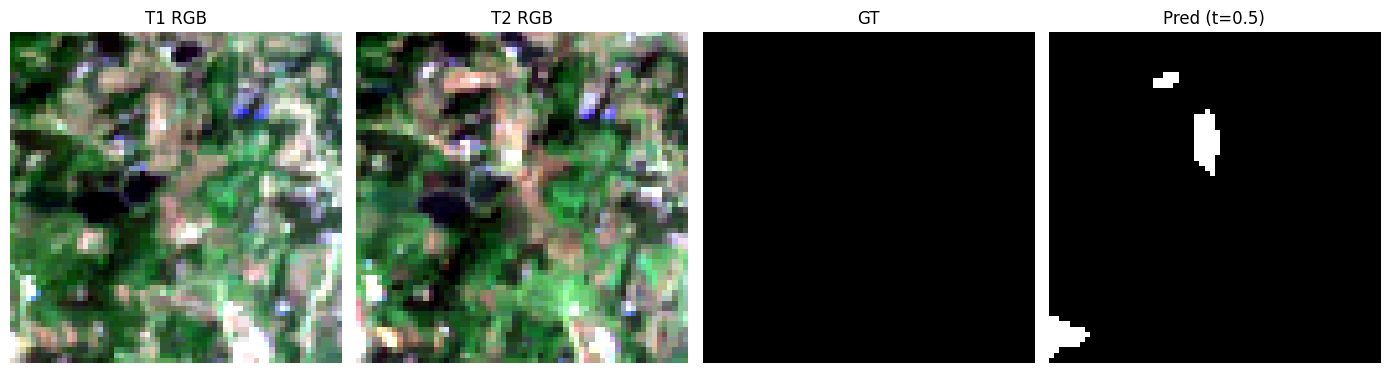

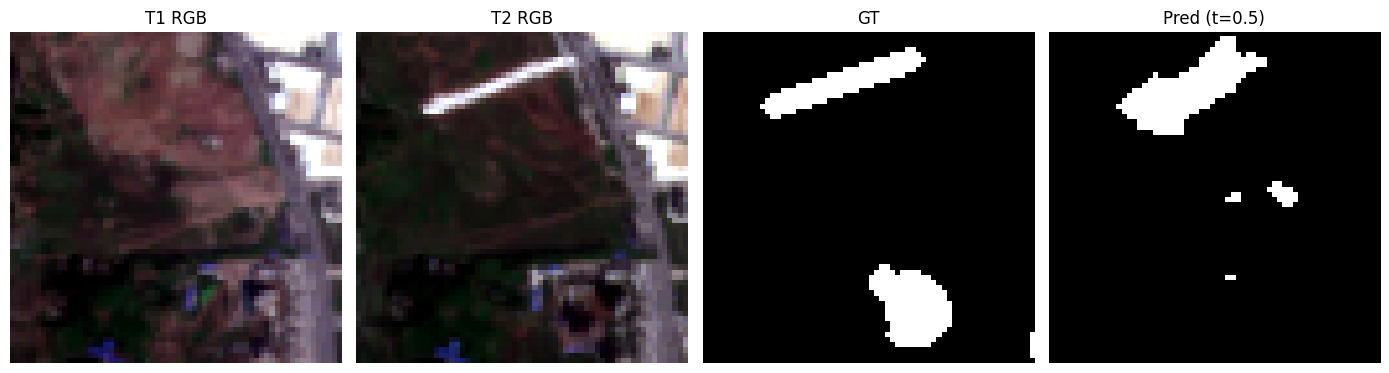

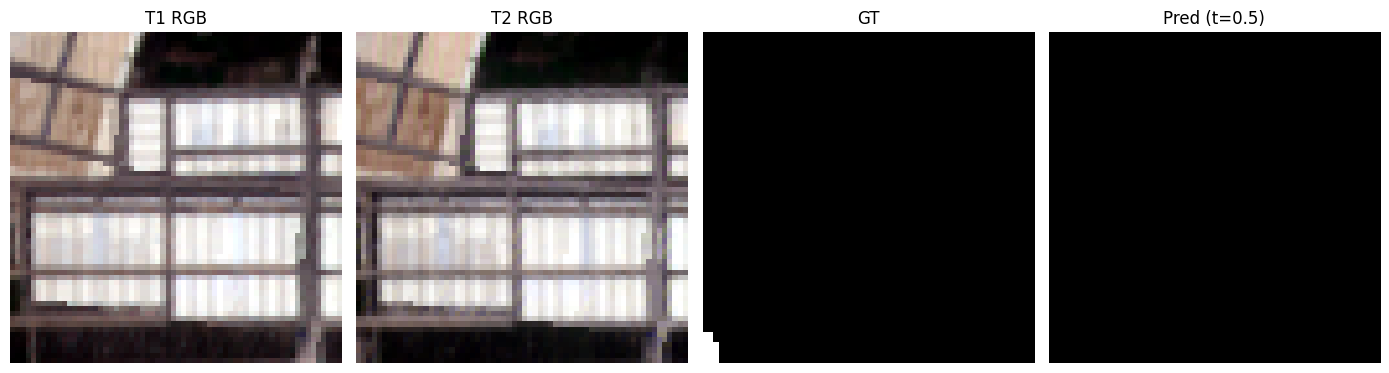

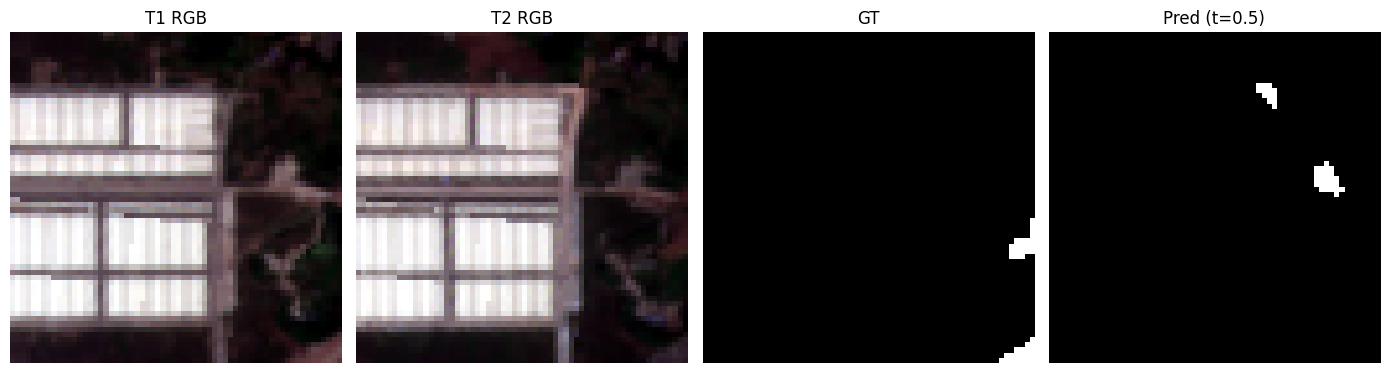

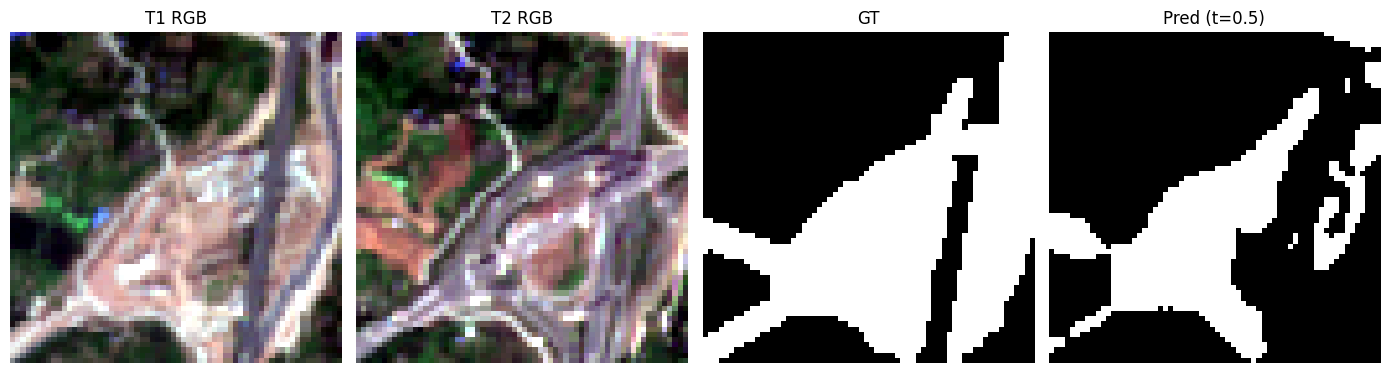

In [13]:
visualize_preds(model, val_ds, n=5)

In [11]:
from preprocess import read_single_band_stack, same_tiles_indices, norm_p02_p98, S2_BAND_ORDER

def load_city_rect_13(images_root, city):
    t1_dir = f"{images_root}/{city}/imgs_1_rect"
    t2_dir = f"{images_root}/{city}/imgs_2_rect"
    t1, meta1 = read_single_band_stack(t1_dir, S2_BAND_ORDER, strict=True)  # (H,W,13)
    t2, meta2 = read_single_band_stack(t2_dir, S2_BAND_ORDER, strict=True)  # (H,W,13)
    assert t1.shape == t2.shape, f"Shape mismatch: t1={t1.shape}, t2={t2.shape}"
    return t1, t2, meta1


def sliding_predict_full(model, t1, t2, tile=TILE, stride=STRIDE, batch_size=8):
    """
    Sliding-window inference over full scenes.
    - t1, t2: (H, W, C) float arrays (Sentinel-2: C=13)
    - model: Siamese U-Net with sigmoid output -> probabilities in [0,1]
    Returns: prob (H, W) float32
    """
    H, W, C = t1.shape
    ys = same_tiles_indices(H, tile, stride)
    xs = same_tiles_indices(W, tile, stride)

    prob = np.zeros((H, W), dtype=np.float32)
    cnt  = np.zeros((H, W), dtype=np.float32)

    batch_t1, batch_t2, locs = [], [], []

    def flush_batch():
        nonlocal prob, cnt, batch_t1, batch_t2, locs
        if not batch_t1:
            return
        x1 = np.stack(batch_t1, 0).astype(np.float32)       # (B, tile, tile, C)
        x2 = np.stack(batch_t2, 0).astype(np.float32)       # (B, tile, tile, C)

        # Model already outputs probabilities (sigmoid head)
        p = model.predict([x1, x2], verbose=0)[..., 0]       # (B, tile, tile)

        for k, (y1, y2, x1_, x2_, h, w) in enumerate(locs):
            prob[y1:y2, x1_:x2_] += p[k, :h, :w]
            cnt [y1:y2, x1_:x2_] += 1.0

        batch_t1.clear(); batch_t2.clear(); locs.clear()

    for y in ys:
        for x in xs:
            y2 = min(y + tile, H)
            x2_ = min(x + tile, W)

            a1 = t1[y:y2, x:x2_, :].astype(np.float32, copy=False)
            a2 = t2[y:y2, x:x2_, :].astype(np.float32, copy=False)

            # Per-crop normalization (match training; uses your norm function)
            a1 = norm_p02_p98(a1)
            a2 = norm_p02_p98(a2)

            # Pad to tile size if on borders
            ph = tile - a1.shape[0]
            pw = tile - a1.shape[1]
            if ph > 0 or pw > 0:
                a1 = np.pad(a1, ((0, ph), (0, pw), (0, 0)), mode='edge')
                a2 = np.pad(a2, ((0, ph), (0, pw), (0, 0)), mode='edge')

            batch_t1.append(a1)
            batch_t2.append(a2)
            locs.append((y, y2, x, x2_, y2 - y, x2_ - x))

            if len(batch_t1) == batch_size:
                flush_batch()

    flush_batch()

    # Average overlapping predictions
    prob = prob / np.maximum(cnt, 1e-6)
    return prob


def save_mask_tif(path, arr, meta, dtype='uint8'):
    """
    Save 2D array as single-band GeoTIFF, preserving CRS/transform.
    arr: (H, W)
    """
    m = meta.copy()
    m.update(count=1, dtype=dtype)

    with rasterio.open(path, "w", **m) as dst:
        if arr.ndim == 2:
            dst.write(arr, 1)
        else:
            dst.write(arr)


# -------- Load weights & run inference on a test city --------
model.load_weights(ckpt_path)
print("Loaded best weights:", ckpt_path)

TEST_CITY = "dubai"  # change as needed
t1_full, t2_full, meta_full = load_city_rect_13(IMAGES_ROOT, TEST_CITY)
print("Full scene shape:", t1_full.shape)

prob = sliding_predict_full(model, t1_full, t2_full, tile=TILE, stride=STRIDE, batch_size=8)
mask = (prob > 0.5).astype(np.uint8)

out_dir = f"{OUT_ROOT}/inference"
Path(out_dir).mkdir(parents=True, exist_ok=True)
prob_path = f"{out_dir}/{TEST_CITY}_prob.tif"
mask_path = f"{out_dir}/{TEST_CITY}_mask.tif"

save_mask_tif(prob_path, prob.astype(np.float32), meta_full, dtype='float32')
save_mask_tif(mask_path, mask, meta_full, dtype='uint8')
print("Saved:", prob_path, mask_path)

Loaded best weights: /content/oscd_tf/models/best_model.weights.h5
Full scene shape: (774, 634, 13)
Saved: /content/oscd_tf/inference/dubai_prob.tif /content/oscd_tf/inference/dubai_mask.tif


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


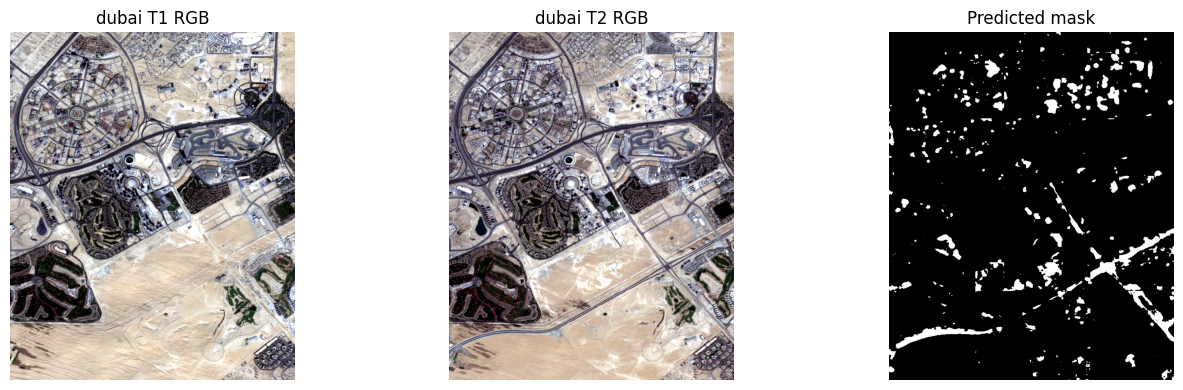

prob stats min/mean/max: 1.314597284363117e-06 0.07648438215255737 0.9989383816719055
mask unique: (array([0, 1], dtype=uint8), array([457047,  33669]))


In [12]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1); plt.imshow(np.clip(norm_p02_p98(t1_full)[..., [3,2,1]], 0,1)); plt.title(f"{TEST_CITY} T1 RGB"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(np.clip(norm_p02_p98(t2_full)[..., [3,2,1]], 0,1)); plt.title(f"{TEST_CITY} T2 RGB"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(mask, cmap='gray', vmin=0, vmax=1); plt.title("Predicted mask"); plt.axis('off')
plt.tight_layout(); plt.show()

# quick stats
print("prob stats min/mean/max:", float(prob.min()), float(prob.mean()), float(prob.max()))
print("mask unique:", np.unique(mask, return_counts=True))
